In [1]:
import os
import logging
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
import json


logger = logging.getLogger(__name__)

/home/fjiriges/anaconda3/envs/cuBERT/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data processing 

In [70]:
# read data from jsonl file as a pandas dataframe 
import pandas as pd
import json
file_path = '/home/fjiriges/CodeXGLUE/Code-Code/Defect-detection/dataset/test.jsonl'

examples = [] 
labels = []
with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                examples.append(' '.join(js['func'].split()))
                labels.append(js['target'])
                

In [71]:
len(examples), len(labels)

(2732, 2732)

In [29]:
## Before tokenization 
defect_func = [examples[i] for i in range(len(examples)) if labels[i] == 1]
defect_func_len = [len(examples[i].split()) for i in range(len(examples)) if labels[i] == 1]
non_defect_func = [examples[i] for i in range(len(examples)) if labels[i] == 0]
non_defect_func_len = [len(examples[i].split()) for i in range(len(examples)) if labels[i] == 0]

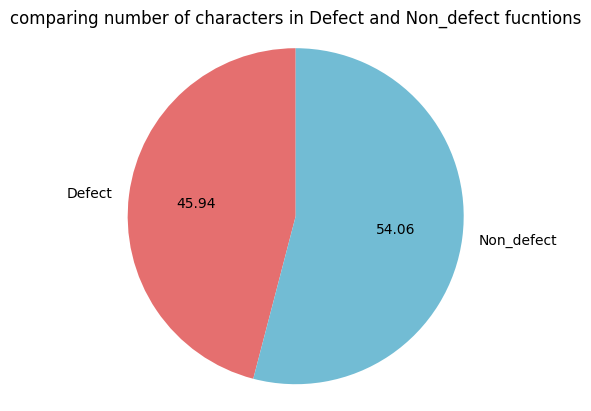

In [31]:
from matplotlib import pyplot as plt

# comparing total length of characters utterred
tot_chars = []
tot_chars.append(len(defect_func))
tot_chars.append(len(non_defect_func))
labels = 'Defect','Non_defect'
colors = ['#e56f6f', "#72bcd4"]
ax1=plt.pie(tot_chars, colors=colors, shadow=False, startangle=90, labels=labels, autopct='%.2f')
plt.axis('equal')
plt.title("comparing number of characters in Defect and Non_defect fucntions")
plt.show()

#### Function length historgram charts 

In [50]:
defect_func_len = [len(examples[i].split(" ")) for i in range(len(examples)) if labels[i] == 1]
non_defect_fun_len = [len(examples[i].split(" ")) for i in range(len(examples)) if labels[i] == 0]

In [49]:
print("The maxmum and minimum Len for defect func:", max(defect_func_len), min(defect_func_len))

print("The maxmum and minimum Len for defect func:", max(non_defect_fun_len), min(non_defect_fun_len))

The maxmum and minimum Len for defect func: 12195 4
The maxmum and minimum Len for defect func: 7755 4


In [72]:
len(examples), len(defect_func_len), len(non_defect_fun_len)

(2732, 1255, 1477)

Text(0.5, 1.0, 'comparing number of tokens per function distribution in Defect and non_defect functions')

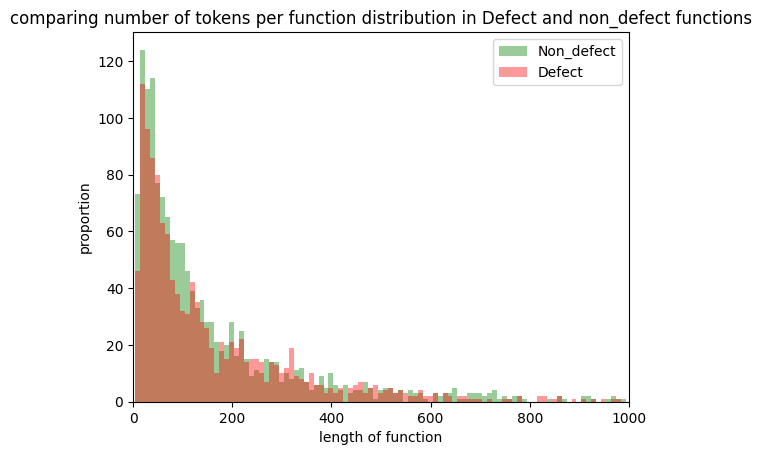

In [74]:
plt.hist(non_defect_fun_len, range=[0,1000],
         bins=range(min(non_defect_fun_len), max(non_defect_fun_len) + 1, 10), 
              alpha=0.4, color="green")
plt.hist(defect_func_len, range=[0,1000], 
         bins=range(min(defect_func_len), max(defect_func_len) + 1, 10), 
              alpha=0.4, color="red")

labels_ = ["Non_defect", 'Defect']
plt.legend(labels_)
plt.xlabel("length of function")
plt.xlim(0, 1000)
plt.ylabel("proportion")
plt.title("comparing number of tokens per function distribution in Defect and non_defect functions")

In [81]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 idx,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.idx=str(idx)
        self.label=label

In [82]:
def convert_examples_to_features(js, tokenizer, block_size=512):
    #source
    code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    
    return InputFeatures(source_tokens,source_ids,js['idx'],js['target'])

In [78]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, tokenizer, file_path=None, block_size=512):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                self.examples.append(convert_examples_to_features(js,tokenizer, block_size))
                
        if 'train' in file_path:
            for idx, example in enumerate(self.examples[:3]):
                    logger.info("*** Example ***")
                    logger.info("idx: {}".format(idx))
                    logger.info("label: {}".format(example.label))
                    logger.info("input_tokens: {}".format([x.replace('\u0120','_') for x in example.input_tokens]))
                    logger.info("input_ids: {}".format(' '.join(map(str, example.input_ids))))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i].input_ids),torch.tensor(self.examples[i].label)
    

In [79]:
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")



In [83]:
eval_data_file = '/home/fjiriges/CodeXGLUE/Code-Code/Defect-detection/dataset/test.jsonl'
eval_dataset = TextDataset(tokenizer, eval_data_file, block_size=512)

In [86]:
# model = RobertaModel.from_pretrained("microsoft/codebert-base")
# model = model.to(device)

from model import Model

from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

model_name_or_path = "microsoft/codebert-base"

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta'] 
if model_name_or_path:
    model = model_class.from_pretrained(args.model_name_or_path,
                                        from_tf=bool('.ckpt' in args.model_name_or_path),
                                        config=config,
                                        cache_dir=args.cache_dir if args.cache_dir else None)    
else:
    model = model_class(config)

model=Model(model,config,tokenizer,args)
    

In [88]:
eval_dataloader = DataLoader(eval_dataset, batch_size=128,num_workers=4,pin_memory=True)
# Eval!
eval_loss = 0.0
nb_eval_steps = 0
model.eval()
logits=[] 
labels=[]

for batch in eval_dataloader:
    inputs = batch[0].to(device)
    print(inputs.shape)  
    label=batch[1].to(device) 
    with torch.no_grad():
        lm_loss,logit = model(inputs,label)
        
        eval_loss += lm_loss.mean().item()
        logits.append(logit.cpu().numpy())
        labels.append(label.cpu().numpy())
    nb_eval_steps += 1
    
logits=np.concatenate(logits,0)
labels=np.concatenate(labels,0)
preds=logits[:,0]>0.5
eval_acc=np.mean(labels==preds)
eval_loss = eval_loss / nb_eval_steps
perplexity = torch.tensor(eval_loss)
        
result = {
    "eval_loss": float(perplexity),
    "eval_acc":round(eval_acc,4),
}

torch.Size([128, 512])


ValueError: Wrong shape for input_ids (shape torch.Size([128, 512])) or attention_mask (shape torch.Size([128]))

In [77]:
def evaluate(args, model, tokenizer,eval_when_training=False):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = TextDataset(tokenizer, args, args.eval_data_file)

    if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(eval_output_dir)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size,num_workers=4,pin_memory=True)

    # multi-gpu evaluate
    if args.n_gpu > 1 and eval_when_training is False:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()
    logits=[] 
    labels=[]
    for batch in eval_dataloader:
        inputs = batch[0].to(args.device)        
        label=batch[1].to(args.device) 
        with torch.no_grad():
            lm_loss,logit = model(inputs,label)
            eval_loss += lm_loss.mean().item()
            logits.append(logit.cpu().numpy())
            labels.append(label.cpu().numpy())
        nb_eval_steps += 1
    logits=np.concatenate(logits,0)
    labels=np.concatenate(labels,0)
    preds=logits[:,0]>0.5
    eval_acc=np.mean(labels==preds)
    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.tensor(eval_loss)
            
    result = {
        "eval_loss": float(perplexity),
        "eval_acc":round(eval_acc,4),
    }
    return result